#Machine Learning Assignment-4

#Title: Visual Q&A

#Objective: To implement a visual question answering framework to predict an answer to that question given a pair of image and question

'''
Student names and IDs:
Team - 10 : Team Members: 
---
Mayukha Thumiki (1002055616)

---
Chandrahas Guttikonda (1002049825)

---
Jayadev Mandava (1002062733)

---
Bhuvaneswari Yendluru (1002081299)

---
Karthik Babu Vadloori (1002064678)
'''

###References:
#####https://www.geeksforgeeks.org/convolutional-neural-network-cnn-in-machine-learning/
#####https://analyticsindiamag.com/how-to-code-your-first-lstm-network-in-keras/
#####https://www.analyticsvidhya.com/blog/2022/01/the-complete-lstm-tutorial-with-implementation/
#####https://towardsdatascience.com/building-a-multi-output-convolutional-neural-network-with-keras-ed24c7bc1178
#####https://datascience.stackexchange.com/questions/31746/how-to-include-labels-in-sns-heatmap

In [44]:
#importing require python classes and packages
import numpy as np
import pickle, os, keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from keras.layers import Conv2D,MaxPooling2D,Flatten
from keras.layers import Input,LSTM,Embedding,Dense
from keras.models import Model,Sequential
import json
import cv2
import matplotlib.pyplot as plt
import pandas
import seaborn as sns

In [61]:
#generate image attention map
def getImageMap(image, question_data):
    image = cv2.imread(image)
    array=question_data.split(" ")
    map_attention = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    map_attention = cv2.resize(map_attention,(len(array),len(array)))
    return map_attention,array

In [50]:
def readImage(imagePath):
    img = cv2.imread(imagePath)
    img = cv2.resize(img, (32, 32))
    return img

In [51]:
#read and load question, images and answers, if already processed
if os.path.exists("data/questionList.npy"):
    questionArray = np.load("data/questionList.npy")
    imageArray = np.load("data/imageList.npy")
    answerArray =np.load("data/answerList.npy")
    images = np.load("data/images.npy")
else:#if not processed then load JSON dataset file
    with open('QuestionDataset/MultipleChoice_abstract_v002_test2015_questions.json', 'r') as file:
        qs_data = json.load(file)
    file.close()
    #read all questions and images list from JSON file
    questionList = qs_data.get('questions')
    questionArray = []
    imageArray = []
    answerArray = []
    #loop entire dataset
    for i in range(len(questionList)):
        ql = questionList[i]
        question_content = ql['question']#read all question and answers
        image_content = ql['image_id']
        answer_content = ql['multiple_choices']
        if os.path.exists('images/abstract_v002_test2015_0000000'+str(image_content)+".png"):
            ans = None
            for j in range(len(answer_content)):
                temp = answer_content[j].split(" ")
                if len(temp) > 1:
                    ans = answer_content[j]
                    break
            if ans is not None:
                imageArray.append('images/abstract_v002_test2015_0000000'+str(image_content)+".png")
                questionArray.append(question_content)
                answerArray.append(ans)
        if len(imageArray) > 100:
            break
    questionArray = np.asarray(questionArray)
    imageArray = np.asarray(imageArray)
    answerArray = np.asarray(answerArray)
    np.save("data/questionList", questionArray)
    np.save("data/imageList", imageArray)
    np.save("data/answerList", answerArray)
    images = []
    for i in range(len(imageArray)):
        imgs = readImage(imageArray[i])
        images.append(imgs)
    images = np.asarray(images)
    np.save("data/images", images)
print()
print("Total images found in Visual Question Answer Dataset = "+str(len(images)))
print()


Total images found in Visual Question Answer Dataset = 101



In [52]:
#creating word2vec vector from question dataset
wordToken = Tokenizer()
wordToken.fit_on_texts(questionArray)
vocab_size = len(wordToken.word_index) + 1
print('Visual Question Vocabulary Size = '+str(vocab_size))
trainingSequences = wordToken.texts_to_matrix(questionArray)

Visual Question Vocabulary Size = 185


In [53]:
'''
taking all answers as the target value
'''
unique_answers = np.unique(answerArray)
unique_answers = unique_answers.tolist()
target = []
for j in range(len(answerArray)):
    label = unique_answers.index(answerArray[j])
    target.append(label)
target = np.asarray(target)
Y = to_categorical(target)
print("Target Answers Labels : "+str(target))

Target Answers Labels : [75 59 58 78 56 11 73 65 77 64  0 89 19 86 20 61 81 38 88 83  9 47 92 45
 36  3  5 24  7 91 42 76 13 40 16 60 48 20 43 69 33 72 25 14 51  4 85 23
 67 15 68 17 55  3 35 70 37 53 49 32 27 80 61 46 82 54 50  6 87 34  2  8
 62 39 41  3 30 10 79 44 22 84 90 63 52 94 12 93 21 71 39 66 28 31 74 95
 29 57 26  1 18]


Dataset normalization & Shuffling Task Done


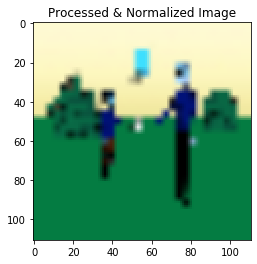

In [54]:
#dataset preprocessing such as normalization, shuffling 
location = np.arange(images.shape[0])
np.random.shuffle(location)
images = images[location]
Y = Y[location]
trainingSequences = trainingSequences[location]
answerArray = answerArray[location]
images=images.astype('float32')
images=images/255
print("Dataset normalization & Shuffling Task Done")
#visualize processed image
temp = images[23]
processedImage = cv2.resize(temp, (111,111))
plt.imshow(processedImage)
plt.title("Processed & Normalized Image")
plt.show()

In [59]:
#read & process TEST data
valQuestions = pandas.read_csv("TestData/question.txt",header=None,delimiter="#")
valAnswers = pandas.read_csv("TestData/answer.txt",header=None,delimiter="#")
valQuestions = valQuestions.values
valAnswers = valAnswers.values
testImages = []
testQuestions = []
testAnswers = []
#load all test images, questions and answers for validation
for i in range(len(valQuestions)):
    img_name = valQuestions[i,0]
    quest = valQuestions[i,1]
    answer = valAnswers[i,1]
    imgs = readImage("TestData/images/"+img_name)
    testImages.append(imgs)
    testQuestions.append(quest)
    testAnswers.append(answer)    
testImages = np.asarray(testImages)
testQuestions = np.asarray(testQuestions)
testAnswers = np.asarray(testAnswers)
testImages = testImages.astype('float32')
testImages = testImages/255   #normalize image
test_Sequences = wordToken.texts_to_matrix(testQuestions)#convert question to matrix or features
test_Sequences = np.asarray(test_Sequences)
y_test = []
for i in range(len(testAnswers)):
    location = unique_answers.index(testAnswers[i])#get labels for answers
    y_test.append(location)
y_test = np.asarray(y_test)
print("Test data loaded with token vocabulary shapes : "+str(test_Sequences.shape))

Test data loaded with token vocabulary shapes : (101, 185)


In [60]:
'''
creating CNN model to encode VQA images
'''
cnn_model = Sequential()
cnn_model.add(Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(32,32,3)))
cnn_model.add(Conv2D(64,(3,3),activation='relu'))
cnn_model.add(MaxPooling2D((2,2)))
cnn_model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
cnn_model.add(Conv2D(32,(3,3),activation='relu'))
cnn_model.add(MaxPooling2D((2,2)))
cnn_model.add(Conv2D(16,(3,3),activation='relu', padding='same'))
cnn_model.add(Conv2D(16,(3,3),activation='relu'))
cnn_model.add(Conv2D(16,(3,3),activation='relu'))
cnn_model.add(MaxPooling2D((2,2)))
cnn_model.add(Flatten())
image_input = Input(shape=(32,32,3))
encoded_images = cnn_model(image_input)
# creating LSTM model to encode question and answers
question_input = Input(shape=(185,),dtype='int32')
embedded_question = Embedding(input_dim=100,output_dim=56,input_length=185)(question_input)
encoded_question = LSTM(56)(embedded_question)
# fusion(combining) CNN with encoded images and LSTM encoded question and answers
fusion=keras.layers.concatenate([encoded_question,encoded_images])
output=Dense(Y.shape[1],activation='softmax')(fusion)
cnn_Model = Model(inputs=[image_input, question_input],outputs=output)
#compile the fusion model
cnn_Model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
#if model already trained then load it else trained the model
if os.path.exists("data/weights.hdf5")==False:
    checkpoint = ModelCheckpoint(filepath='data/weights.hdf5',verbose=1,save_best_only=True)
    hist = cnn_Model.fit([images, trainingSequences], Y, validation_data=([images, trainingSequences], Y),shuffle=True,epochs=50,callbacks=[checkpoint],verbose=1)
else:
    cnn_Model.load_weights("data/weights.hdf5")
#test the model on test questions and answers   
y_pred = cnn_Model.predict([testImages, test_Sequences])
y_pred = np.argmax(y_pred, axis=1)
#calculate accuracy 
encoded_accuracy = accuracy_score(y_pred, y_test)
print()
print("Fusion Visual Question Answers Accuracy on Validation Data : "+str(encoded_accuracy))
print()


Fusion Visual Question Answers Accuracy on Validation Data : 0.6435643564356436



Validation Question = What color are the chairs?
Validation Correct Answer = standing in water
Predicted Answer = on sidewalk


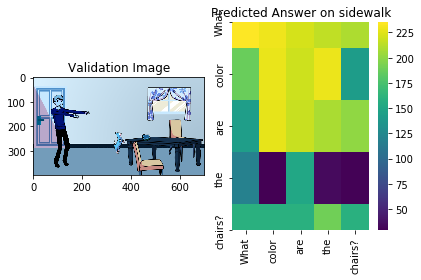

Validation Question = How many bushes are in the background?
Validation Correct Answer = sun rays
Predicted Answer = bird nests


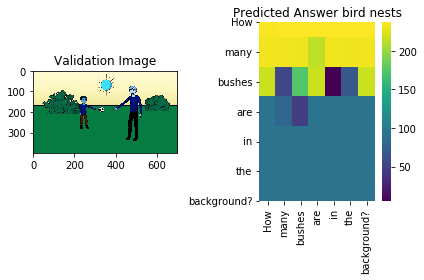

Validation Question = Is there a deer hiding behind the bush?
Validation Correct Answer = sit on floor
Predicted Answer = sit on floor


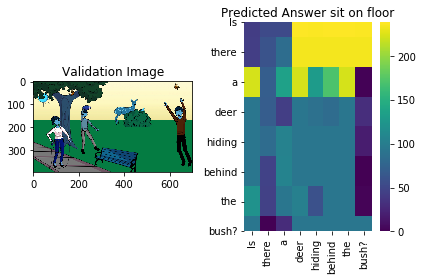

Validation Question = What type of story is the man playing with?
Validation Correct Answer = paw print
Predicted Answer = 2 boys


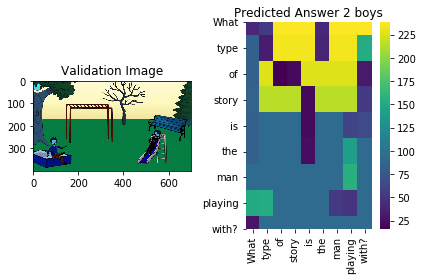

Validation Question = How many drawers down the dresser have?
Validation Correct Answer = catching boy
Predicted Answer = coat rack


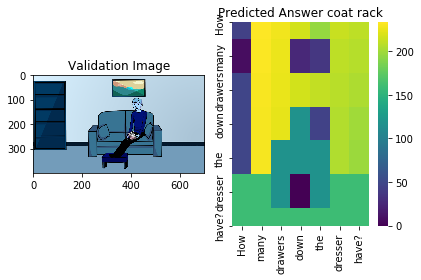

Validation Question = Where is the window?
Validation Correct Answer = on wall
Predicted Answer = on wall


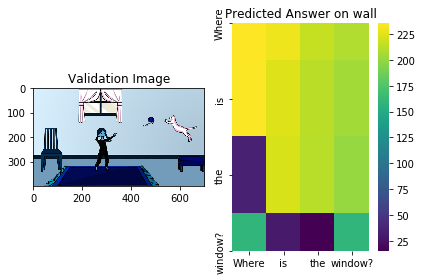

Validation Question = What is the man reaching for?
Validation Correct Answer = video games
Predicted Answer = beside blanket


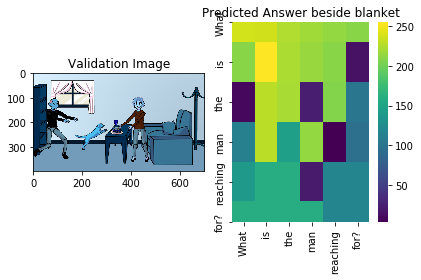

Validation Question = Are those fish good for eating?
Validation Correct Answer = no brand
Predicted Answer = no brand


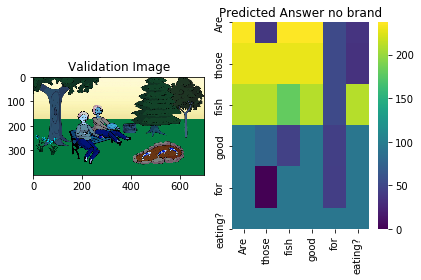

Validation Question = Where are the children playing?
Validation Correct Answer = in park
Predicted Answer = in park


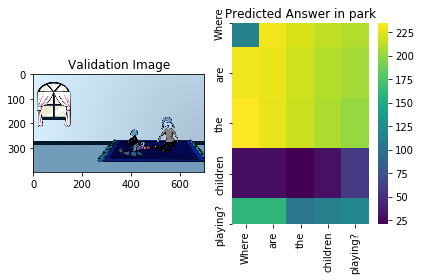

Validation Question = Are the woman and little girl picking a flower?
Validation Correct Answer = dog and drink
Predicted Answer = bear, book, stapler


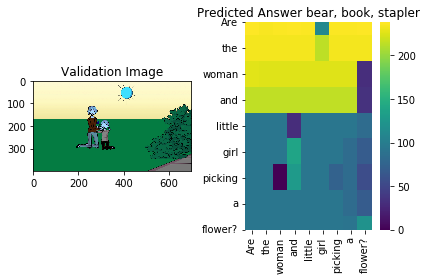

Validation Question = What is on the rug?
Validation Correct Answer = left of girl
Predicted Answer = left of girl


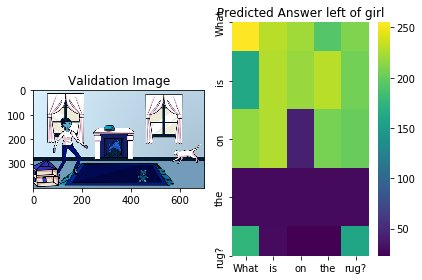

Validation Question = Is he doing gymnastics?
Validation Correct Answer = it's not mealtime
Predicted Answer = on stone


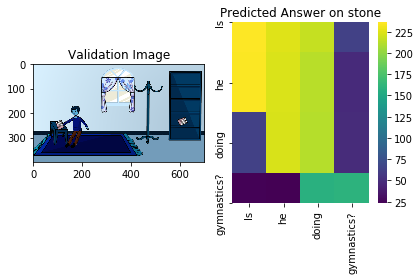

Validation Question = What room is this?
Validation Correct Answer = no chair
Predicted Answer = coat rack


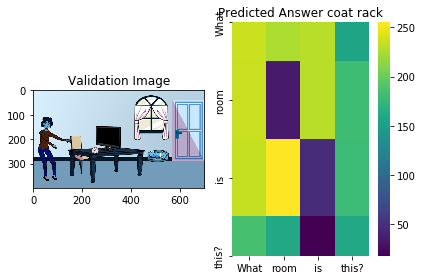

Validation Question = Is the boy as tall as the tree?
Validation Correct Answer = roast it
Predicted Answer = roast it


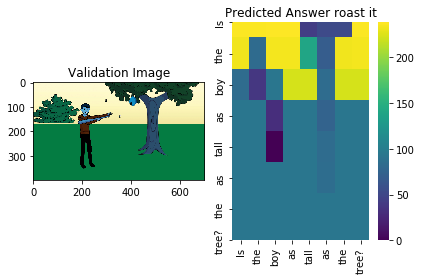

Validation Question = What is on the tree?
Validation Correct Answer = dropped book
Predicted Answer = dropped book


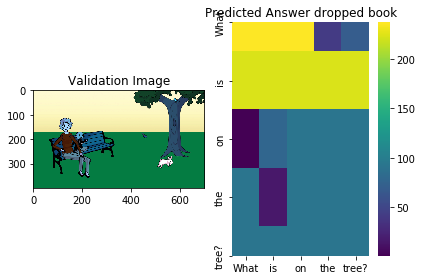

Validation Question = Is the man sitting?
Validation Correct Answer = baseball and bat
Predicted Answer = to man


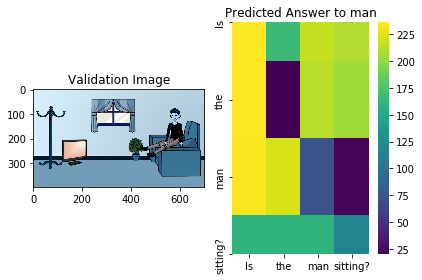

Validation Question = How many koi?
Validation Correct Answer = playing video game
Predicted Answer = by pond and by pine tree


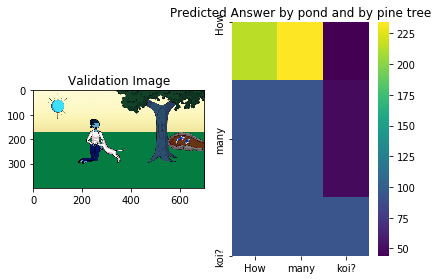

Validation Question = What is on top of the table?
Validation Correct Answer = carrying it
Predicted Answer = on her eyes


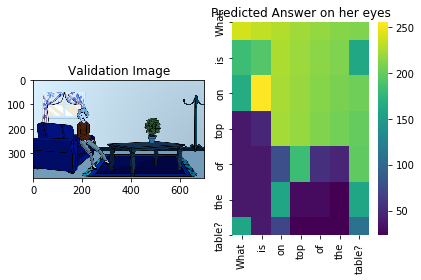

Validation Question = How many couches are there?
Validation Correct Answer = her face
Predicted Answer = rocking horse


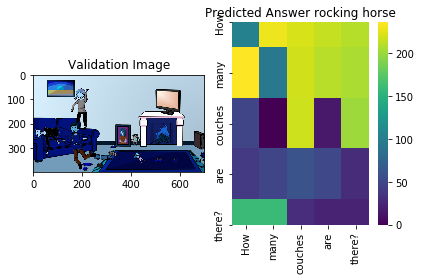

Validation Question = How many legs are on the ground?
Validation Correct Answer = older woman
Predicted Answer = no dog


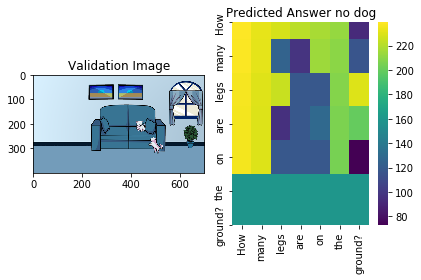

Validation Question = How many can have tea?
Validation Correct Answer = flowers and bushes
Predicted Answer = tea set


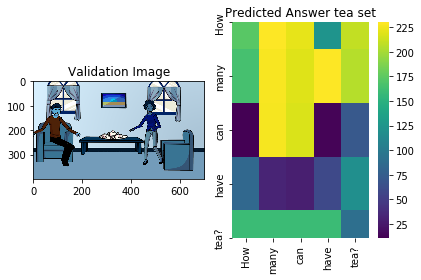

Validation Question = What is on the table?
Validation Correct Answer = next to bookcase
Predicted Answer = on boy's lap


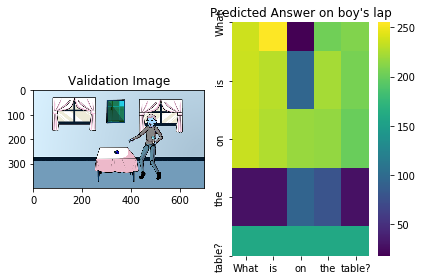

Validation Question = Are the windows the same size?
Validation Correct Answer = no one else to play with
Predicted Answer = bear and horse


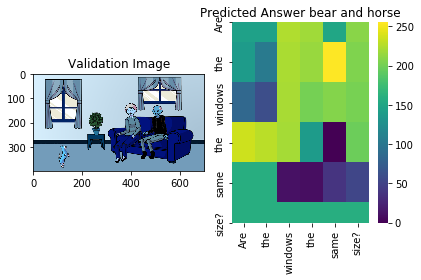

Validation Question = What color is the scooter?
Validation Correct Answer = he likes reading
Predicted Answer = he likes reading


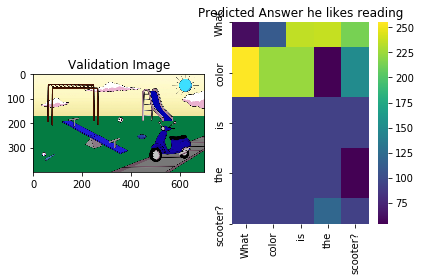

Validation Question = Does the woman look nervous?
Validation Correct Answer = on windows
Predicted Answer = on windows


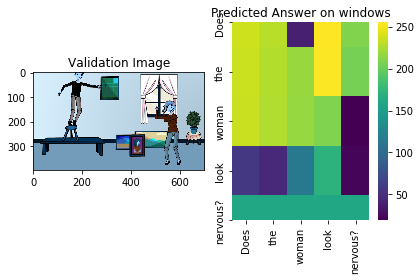

Validation Question = Is the girl doing the splits?
Validation Correct Answer = at little girl
Predicted Answer = girl in black


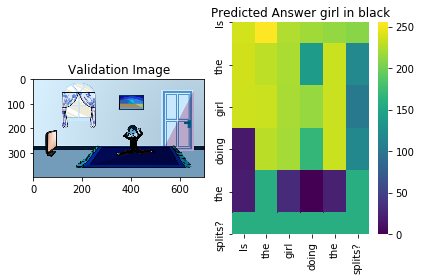

Validation Question = Is it a nice day?
Validation Correct Answer = sunny day
Predicted Answer = mother and son


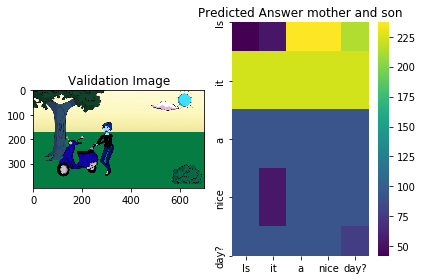

Validation Question = Is the deer sleeping?
Validation Correct Answer = to keep from getting burned
Predicted Answer = wine bottle


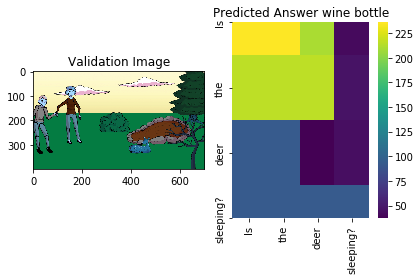

Validation Question = Is this a kitchen?
Validation Correct Answer = not high
Predicted Answer = woman's hand


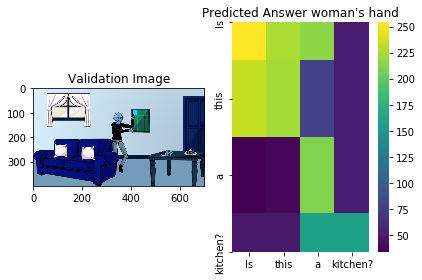

Validation Question = Are they a happy couple?
Validation Correct Answer = with wood
Predicted Answer = couch, rug and pants


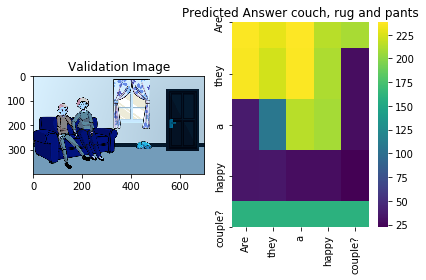

In [62]:
#loop all test question and images to predict answer and then plot attention map
imgList = []
for i in range(len(testImages)):
    if valQuestions[i,0] not in imgList and len(imgList) < 30:
        imgList.append(valQuestions[i,0])#get image name
        image = cv2.imread("TestData/images/"+valQuestions[i,0])#read image
        imgs = []
        imgs.append(testImages[i])
        imgs = np.asarray(imgs) #convert image as numpy
        test_Sequences = wordToken.texts_to_matrix(valQuestions[i,1])#convert text question into numeric vector
        test_Sequences = np.asarray(test_Sequences)
        quest = []
        quest.append(test_Sequences)
        quest = np.asarray(test_Sequences)
        y_pred = cnn_Model.predict([imgs, quest])#perform prediction with test image and question to predict answer
        y_pred = np.argmax(y_pred, axis=1)
        print("Validation Question = "+testQuestions[i])#display validate question, answer and pedicted answer
        print("Validation Correct Answer = "+testAnswers[i])
        print("Predicted Answer = "+unique_answers[y_pred[0]])
        image_map, array = getImageMap("TestData/images/"+valQuestions[i,0], valQuestions[i,1])#get image attention map
        fig, axs = plt.subplots(nrows=1, ncols=2)
        axs[0].set_title("Validation Image")
        axs[1].set_title("Attention Map Image")
        axs[0].imshow(image)
        sns.heatmap(image_map,xticklabels=array,yticklabels=array,cmap="viridis",fmt="g",ax=axs[1])
        fig.tight_layout()
        plt.title("Predicted Answer "+unique_answers[y_pred[0]])
        plt.show()
    
    